In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

from IPython import display

# from utils import Logger
from IPython.display import clear_output
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score
from collections import Counter
plt.ion()
plt.show()


https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

In [2]:

DATA_FOLDER = './data/MNIST'

def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [3]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader) #600

torch.Size([100, 1, 28, 28]) torch.Size([28, 28])
(28, 28)


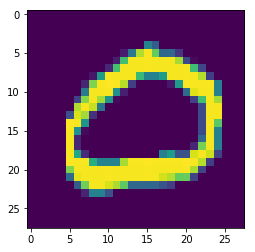

In [4]:
for i, x in enumerate(data_loader):
    if(i == 1):
        break
    a = x[0][0].view(28, 28)
    print(x[0].shape, a.shape)
    plt.imshow(a)
    print(a.numpy().shape)
    

In [5]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [6]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1


In [7]:
def get_gaussian(mu, sigma, n):
    return torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_noise(m, n):
    return torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

## MODEL 1

### Input for Generator : (100, 100)  
hidden layer = 50

Structure:  
nn.Linear(100, 50)   
nn.Linear(50, 50)  
nn.Linear(50, 784)

=> Output = (100, 784)

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

### Input for Discriminator : (100, 784)  
hidden layer = 50

Structure:  
nn.Linear(784, 50)   
nn.Linear(50, 50)  
nn.Linear(50, 1)  

=> Output = (100, 1)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [12]:
# Model params
g_input_size = 80    # Random noise dimension coming into generator, per output vector
g_hidden_size = 256   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 784   # Minibatch size - cardinality of distributions
d_hidden_size = 256   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
batch_size = 100

G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=d_input_size)
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
# d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
# g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

# Optimizers
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

212 0


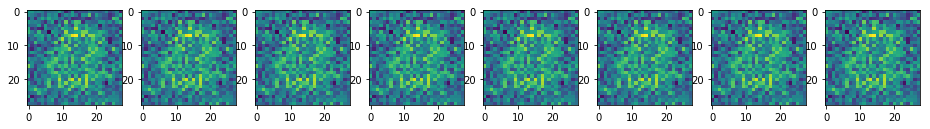

KeyboardInterrupt: 

In [14]:
d_losses = []
d_acc = []
prediction = None
for epoch in range(1000):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch)) #torch.Size([100, 784])
#         print(real_data.size())
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_decision = D(real_data)
        d_real_error = criterion(d_real_decision, Variable(torch.ones(100, 1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params


#         #  1B: Train D on fake
        d_gen_input = Variable(get_noise(100, g_input_size)) # torch.Size([100, 100])
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels, torch.Size([100, 784]) 
        d_fake_decision = D(d_fake_data)
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(100, 1)))  # zeros = fake
        d_fake_error.backward()

        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

        
        for g_index in range(1):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(get_noise(100, g_input_size)) # torch.Size([100, 100])
            g_fake_data = G(gen_input)

            dg_fake_decision = D(g_fake_data)
            g_error = criterion(dg_fake_decision, Variable(torch.ones(100, 1)))  # we want to fool, so pretend it's all genuine
            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

#             if prediction is not None :
# #                 print(prediction == g_fake_data)
#                 print(Counter((prediction == g_fake_data).data.numpy().flatten()))
            prediction = g_fake_data


        if (n_batch) % 100 == 0:
            
            # Render images
            clear_output(wait=True)
            print(epoch, n_batch)
            imgs = prediction.view(prediction.size(0), 1, 28, 28)

            plt.figure(figsize=(16, 4))
            n = 8
            for i in range(1,(n + 1)):
                plt.subplot(100 + i + n*10)
                plt.imshow(imgs[i][0].data)
            plt.show()

        

## MODEL 2

In [39]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2))
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2))
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2))

        self.out = nn.Sequential(
            nn.Linear(1024, 784),
            nn.Tanh())

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [40]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))

        self.out = nn.Sequential(
            nn.Linear(256, 1),
            torch.nn.Sigmoid())

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [41]:
# Model params
g_input_size = 80    # Random noise dimension coming into generator, per output vector
g_hidden_size = 256   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 784   # Minibatch size - cardinality of distributions
d_hidden_size = 256   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
batch_size = 100

G = Generator(input_size=g_input_size)
D = Discriminator(input_size=d_input_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

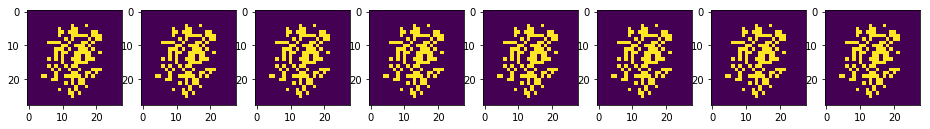

KeyboardInterrupt: 

In [42]:
d_losses = []
d_acc = []
prediction = None
for epoch in range(200):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch)) #torch.Size([100, 784])
#         print(real_data.size())
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_decision = D(real_data)
        d_real_error = criterion(d_real_decision, Variable(torch.ones(100, 1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params


#         #  1B: Train D on fake
        d_gen_input = Variable(get_noise(100, g_input_size)) # torch.Size([100, 100])
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels, torch.Size([100, 784]) 
        d_fake_decision = D(d_fake_data)
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(100, 1)))  # zeros = fake
        d_fake_error.backward()

        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
        ## Loss & accuracy 
#         d_losses.append(d_real_error.data.numpy()[0] + d_fake_error.data.numpy()[0])
#         d_pred = [(d_real_decision > 0.5).data.numpy()[0][0], (d_fake_decision >0.5).data.numpy()[0][0]]
#         truth = [1,0]
#         d_acc.append(accuracy_score(truth, d_pred))
        

        
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(get_noise(100, g_input_size)) # torch.Size([100, 100])
        g_fake_data = G(gen_input)

        dg_fake_decision = D(g_fake_data)
        g_error = criterion(dg_fake_decision, Variable(torch.ones(100, 1)))  # we want to fool, so pretend it's all genuine
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

#             if prediction is not None :
# #                 print(prediction == g_fake_data)
#                 print(Counter((prediction == g_fake_data).data.numpy().flatten()))
        prediction = g_fake_data


        if (n_batch) % 100 == 0:
            
            # Render images
            clear_output(wait=True)
            print(epoch, n_batch)
            imgs = prediction.view(prediction.size(0), 1, 28, 28)

            plt.figure(figsize=(16, 4))
            n = 8
            for i in range(1,(n + 1)):
                plt.subplot(100 + i + n*10)
                plt.imshow(imgs[i][0].data)
            plt.show()
